# Analysis of dynamic/cycling microcompression tests on turgid and plasmolyzed BY2 cells

## Last Updated: October 5, 2020

This document was prepared by Leah Ginsberg, a member of the [Ravichandran Research Group](https://www.ravi.caltech.edu/) at [Caltech](http://www.caltech.edu) in collaboration with [Professor Eleftheria Roumeli](https://sites.google.com/uw.edu/roumeli-research-group/) from [University of Washington](https://www.washington.edu/). 

In [1]:
import numpy as np               # general math operations
import pandas as pd              # pandas dataframes
import os                        # for opening .csv files in different folders
import altair as alt             # pretty plotting
import altair_catplot as altcat  # pretty box & whisker plots
from scipy import signal, stats, fftpack  # filtering and statistics
import matplotlib.pyplot as plt  # plotting histogram

alt.data_transformers.enable('json') # converts data to json for handling large data sets

DataTransformerRegistry.enable('json')

In this notebook, I will detail the preprocessing of force-indentation data from microcompression tests on tobacco (BY2) cells under various chemical treatments. I will explain each step in detail, including the use of the very handy Python package `pandas`. This package allows us to use Pandas `DataFrames`, which are convenient structures for storing data.

Note that there are images that are referred to in this notebook, but the cells that would display the images have been commented out in case you do not have the appropriate files saved. If you'd like to see the images, you can always find and uncomment the blocks by searching for the phrase "Image" in this notebook.

This preprocessing is part of a larger inverse analysis method used to determine a constitutive model for the property of the cell wall. The full process is pictured below, and the highlighted block is executed in this notebook.

The data preprocessing steps are as follows:
1. Import the raw data from microcompression experiments ($Z$, $F$)
3. Calculate the sensor stiffness from filtered calibration data ($S$)
4. Calculate the corrected displacement
5. Calcuate the point of contact by iteratively offsetting force and lowering threshold
6. Fit line to initial portion of displacement curve

### (1) Import the raw data from microcompression experiments ($Z$, $F$)

In this step, I will load data stored on disk into a Python data structure.  I will use `pandas` to read in CSV (comma separated value) files and store the results in the very handy Pandas `DataFrame`. First, I need to organize the data according to the treatment each cell received, the date of the experiment and the day of growth of the cell. All of that information is in the name of the folder containing the data.

In [2]:
dir_list = os.listdir() # prints a list of strings with all folder names in the current working directory
sorbitol_folderNames = []
C2_folderNames = []
ory_folderNames = []
LatB_folderNames = []
ory_sorbitol_folderNames = []
LatB_sorbitol_folderNames = []
water_folderNames = []
for folderName in dir_list:
    if folderName.endswith('_in_C2'):
        C2_folderNames.append(folderName+'/')
    elif folderName.endswith('_oryzalin'):
        ory_folderNames.append(folderName+'/')
    elif folderName.endswith('_LatB'):
        LatB_folderNames.append(folderName+'/')
    elif folderName.endswith('_oryzalin_sorbitol'):
        ory_sorbitol_folderNames.append(folderName+'/')
    elif folderName.endswith('_LatB_sorbitol'):
        LatB_sorbitol_folderNames.append(folderName+'/')
    elif folderName.endswith('_sorbitol'):
        sorbitol_folderNames.append(folderName+'/')
    elif folderName.endswith('_water'):
        water_folderNames.append(folderName+'/')
        
# combine all the lists of folder names into one list
folderNames = ['cycling_tests/in_C2/','cycling_tests/in_LatB/','cycling_tests/in_sorbitol/','cycling_tests/in_water/']

Next, I need to determine which files are calibration data, which are sample data, and which are neither (images).

In [3]:
# Get names of all files to be used as calibration data or sample data
sample_fileNames = []
for folderName in folderNames:
    dir_list = os.listdir(folderName)
    for fileName in dir_list:
        if fileName.startswith('cell') and not fileName.endswith('.png') and not fileName.endswith('.tif') and not fileName.endswith('_corr') and not fileName.endswith('_proc') and not fileName.endswith('.mp4'):
            sample_fileNames.append(folderName + fileName+'_corr')

Now I can will use `pd.read_csv()` to load the data set.  The data are stored in a **DataFrame**, which is one of the data types that makes `pandas` so convenient for use in data analysis.  `DataFrame`s offer mixed data types, including incomplete columns, and convenient slicing, among many, many other convenient features. They are like spreadsheets, only a lot better.

I will load the sample data into a dataframe.

In [4]:
# Organize dataframe by column with additional information about experiment not found in .csv file (date, day of growth, etc.)
df_sample = pd.DataFrame(columns=['Index','Time (s)','Displacement (um)','Pos X (um)','Pos Y (um)','Pos Z (um)','Force A (uN)','Force B (uN)','fileName','indenting','plasmolyzed','treatment','Corrected Displacement (um)'])

# loop through all sample data
for j, fileName in enumerate(sample_fileNames):
    # read data from file to dataframe
    df = pd.read_csv(fileName, header=0, sep='\t', names=['Index','Time (s)','Displacement (um)','Pos X (um)','Pos Y (um)','Pos Z (um)','Force A (uN)','Force B (uN)','fileName','indenting','plasmolyzed','treatment','Corrected Displacement (um)'])
    
    df['fileName']=fileName
    df['indenting']=df['Index']==1.001 # in data files, Index 1.001 indicates indenting data, and Index 2.001 indicates retraction data
    
    # Take information about experiment (date, growth day, treatment) from filename and put into dataframe
    df['cellNum'] = fileName.split('/')[1].split('_')[0][4:]
    if '_in_C2' in fileName:
        df['treatment'] = 'C2'
    elif '_oryzalin_sorbitol' in fileName:
        df['treatment'] = 'oryzalin+sorbitol'
    elif '_LatB_sorbitol' in fileName:
        df['treatment'] = 'LatB+sorbitol'
    elif '_oryzalin' in fileName:
        df['treatment'] = 'oryzalin'
    elif '_LatB' in fileName:
        df['treatment'] = 'LatB'
    elif '_sorbitol' in fileName:
        df['treatment'] = 'sorbitol'
    elif '_water' in fileName:
        df['treatment'] = 'water'
    
    # concatenate all sample dataframes into one dataframe
    df_sample = pd.concat([df_sample, df])

# Take a look at the dataframe we created
df_sample.head()

,Index,Time (s),Displacement (um),Pos X (um),Pos Y (um),Pos Z (um),Force A (uN),Force B (uN),fileName,indenting,plasmolyzed,treatment,Corrected Displacement (um),cellNum
0,1.001,0.123,0.20325,184.00625,-106.00100,49.77075,-10.54090,-0.00129,cycling_tests/in_C2/cell001_corr,True,False,C2,0.244673,
1,1.001,0.228,0.27500,184.00700,-106.00125,49.69900,-10.88703,-0.00336,cycling_tests/in_C2/cell001_corr,True,False,C2,0.317783,
2,1.001,0.346,0.30325,184.00700,-106.00075,49.67075,-10.78654,-0.00192,cycling_tests/in_C2/cell001_corr,True,False,C2,0.345638,
3,1.001,0.466,0.32000,184.00625,-106.00100,49.65400,-10.74826,0.00253,cycling_tests/in_C2/cell001_corr,True,False,C2,0.362238,
4,1.001,0.595,0.34275,184.00600,-106.00075,49.63125,-10.73709,0.00397,cycling_tests/in_C2/cell001_corr,True,False,C2,0.384944,


As you can see, both DataFrames have the same format and both DataFrames are tidy. See this [paper](https://www.jstatsoft.org/article/view/v059i10) by Hadley Wickam for a detailed discussion of tidying data. The basic structure of tidy data is:
1. Each variable is a column
2. Each observation is a row
3. Each type of observational unit is its own table

With our data set up in this way, we can easily find data, say, with a specific treatment using Boolean slicing.

In [5]:
# Remove cell data with unusual/unexpected attributes
df_sample = df_sample[df_sample['fileName']!='BY2_in_C2/cell014_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_C2/cell020_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin/cell053_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin/cell058_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin_sorbitol/cell061_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin_sorbitol/cell067_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin_sorbitol/cell069_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin_sorbitol/cell070_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_oryzalin_sorbitol/cell071_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_sorbitol/cell083_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_sorbitol/cell094_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_sorbitol/cell098_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_sorbitol/cell106_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_sorbitol/cell112_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell115_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell136_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell141_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell142_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell151_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell156_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell157_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell162_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell163_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell169_corr']
df_sample = df_sample[df_sample['fileName']!='BY2_in_water/cell189_corr']

In [6]:
df_sample.insert(10,'Full Indentation', False, False) # initialize full indentation indicator column

In [7]:
for fileName in df_sample['fileName'].unique():
    df = df_sample[df_sample['fileName']==fileName]
    if max(df['Force A (uN)'])>790:
        df_sample.loc[df_sample['fileName']==fileName, 'Full Indentation'] = True
    else:
        df_sample.loc[df_sample['fileName']==fileName, 'Full Indentation'] = False

### (2) Use threshold data to calcuate the point of contact

From Routier-Kierzkowska et al.: "For each measurement cycle, the force signal is offset, so that the mean force signal before the contact point is equal to zero. The contact point is then determined to be the closest point to the maximal indentation that is below a user-defined contact force threshold (usually smaller than 1 $\mu$N). Both force offsetting and contact point detection are performed iteratively, using finer and finer threshold values. Indentation depth is then given by the sensor position corrected for sensor deflection) minus the contact point position." 

In [8]:
df_sample.insert(14,'offset force A (uN)', df_sample['Force A (uN)'],False) # initialize offset force column

In [9]:
# import threshold and location data from csv file
df_thresholds = pd.read_csv('renaming guide for cycling tests.csv', names=['Original Folder', 'Old cell ID', 'folderName', 'cell ID', 'cellNum','cycle','treatment', 'Notes', 'threshold'], header=0, sep=',')
df_thresholds[df_thresholds['cellNum']==116]

,Original Folder,Old cell ID,folderName,cell ID,cellNum,cycle,treatment,Notes,threshold
19,20190926_BY2_d10,3a,cycling_tests/in_water/,cell116,116,1,water,nice and fluffy cell; huge response,4.0
20,20190926_BY2_d10,3b,cycling_tests/in_water/,cell116B,116,2,water,same spot cycle 2,0.5
21,20190926_BY2_d10,3c,cycling_tests/in_water/,cell116C,116,3,water,cycle 3,1.0
22,20190926_BY2_d10,3d,cycling_tests/in_water/,cell116D,116,4,water,cycle 4,1.0


In [10]:
fileNames = df_thresholds['folderName'] + df_thresholds['cell ID']  + '_corr'

for fileName in fileNames:
    # copy threshold and location data to df_sample
    df_thresh = df_thresholds[(df_thresholds['folderName']==(fileName.split('/')[0]+'/'+fileName.split('/')[1]+'/')) & (df_thresholds['cell ID']==fileName.split('/')[2][:-5])].reset_index(drop=True)
    df_sample.loc[df_sample['fileName']==fileName, 'threshold'] = df_thresh['threshold'][0]
    df_sample.loc[df_sample['fileName']==fileName, 'cellNum'] = df_thresh['cellNum'][0]
    df_sample.loc[df_sample['fileName']==fileName, 'cycle'] = df_thresh['cycle'][0]

In [11]:
for fileName in df_sample['fileName'].unique():
    df = df_sample[df_sample['fileName']==fileName]        # select current data set
    end_thr = df['threshold'].unique()[0]             # optimal final threshold value
    print(fileName)
    # sequence of thresholds depending upon final threshold value
    if end_thr>=10.0:
        thresholds = [20,end_thr]
    elif end_thr>=5.0:
        thresholds = [20, 10, end_thr]
    else:
        thresholds = [20, 10, 5, end_thr]

    # loop over threshold values
    for i, threshold in enumerate(thresholds):
        df_indenting = df[df['indenting']]                                            # only concerned with indentation data
        df_precontact = df_indenting[df_indenting['offset force A (uN)']<threshold]   # define all data below threshold as 'precontact'
        force_offset = np.mean(df_precontact['offset force A (uN)'])                  # force offset is mean of precontact data (so that new mean of precontact data is zero)
        df.loc[:,'offset force A (uN)'] = df['offset force A (uN)'] - force_offset    # write new offset force on dataframe
        # Find the contact point (the point where the force data crosses the threshold)
        contact_point = max(df_indenting[df_indenting['offset force A (uN)']<threshold]['Corrected Displacement (um)'])
        # get rid of initial data if needed
        if contact_point>20:
            df = df[df['Corrected Displacement (um)']>contact_point-20]
            df.loc[:,'Corrected Displacement (um)'] = df['Corrected Displacement (um)']-(contact_point-20)
        df.loc[:,'indentation depth (um)'] = df['Corrected Displacement (um)'] - contact_point
        # save results in dataframe
        df_sample.loc[df_sample['fileName']==fileName,'Corrected Displacement (um)'] = df['Corrected Displacement (um)']
        df_sample.loc[df_sample['fileName']==fileName,'indentation depth (um)'] = df['indentation depth (um)']
        df_sample.loc[df_sample['fileName']==fileName,'offset force A (uN)'] = df['offset force A (uN)']
df_sample = df_sample.dropna() # drop rows of dataframe with NaN values

cycling_tests/in_C2/cell001_corr
cycling_tests/in_C2/cell001B_corr
cycling_tests/in_C2/cell001C_corr
cycling_tests/in_C2/cell001D_corr
cycling_tests/in_C2/cell011_corr

C:\Users\leahm\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\leahm\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)



cycling_tests/in_C2/cell011B_corr
cycling_tests/in_C2/cell019_corr
cycling_tests/in_C2/cell019B_corr
cycling_tests/in_LatB/cell029_corr
cycling_tests/in_LatB/cell029B_corr
cycling_tests/in_sorbitol/cell077_corr
cycling_tests/in_sorbitol/cell077B_corr
cycling_tests/in_sorbitol/cell088_corr
cycling_tests/in_sorbitol/cell088B_corr
cycling_tests/in_sorbitol/cell088C_corr
cycling_tests/in_sorbitol/cell090_corr
cycling_tests/in_sorbitol/cell090B_corr
cycling_tests/in_sorbitol/cell103_corr
cycling_tests/in_sorbitol/cell103B_corr
cycling_tests/in_water/cell116_corr
cycling_tests/in_water/cell116B_corr
cycling_tests/in_water/cell116C_corr
cycling_tests/in_water/cell116D_corr
cycling_tests/in_water/cell119_corr
cycling_tests/in_water/cell119B_corr
cycling_tests/in_water/cell125_corr
cycling_tests/in_water/cell125B_corr
cycling_tests/in_water/cell125C_corr
cycling_tests/in_water/cell128_corr
cycling_tests/in_water/cell128B_corr
cycling_tests/in_water/cell128C_corr
cycling_tests/in_water/cell128D

Let's see the final results for our processed data, sorted by treatment and colored by location of the tip on the cell.

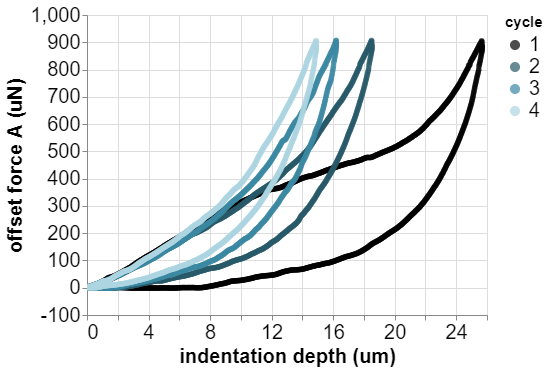

In [12]:
# indenting data from C2 treatment
alt.Chart(df_sample[(df_sample['treatment']=='water')&(df_sample['cellNum']==132)&(df_sample['indentation depth (um)']>0)]).mark_circle().encode(
    x='indentation depth (um)',
    y='offset force A (uN)',
    color = alt.Color('cycle:N',  scale=alt.Scale(domain=[1,2,3,4], range=['#000000','#265868','#3b88a2', '#add4e1' ]))
).configure_text(fontWeight='bold', fontSize=20
).configure_legend(labelFontSize=20, titleFontSize=15
).configure_axis(labelFontSize=20, titleFontSize=20
).configure_point(size=100, strokeWidth=1).interactive()

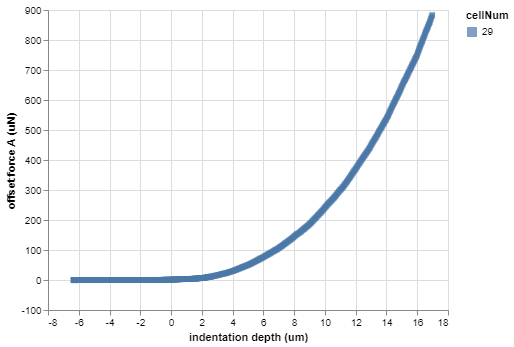

In [13]:
# indenting data from LatB treatment
alt.Chart(df_sample[(df_sample['indenting'])&(df_sample['treatment']=='LatB')]).mark_square().encode(
    x='indentation depth (um)',
    y='offset force A (uN)',
    color = 'cellNum:N'
).interactive()

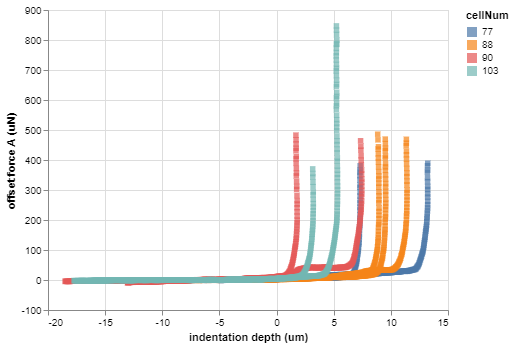

In [14]:
# indenting data from sorbitol treatment
alt.Chart(df_sample[(df_sample['indenting'])&(df_sample['treatment']=='sorbitol')]).mark_square().encode(
    x='indentation depth (um)',
    y='offset force A (uN)',
    color = 'cellNum:N'
).interactive()

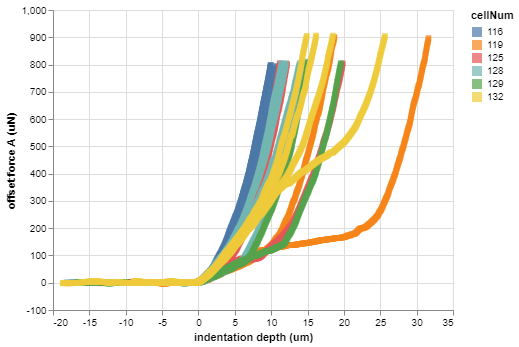

In [15]:
# indenting data from water treatment
alt.Chart(df_sample[(df_sample['indenting'])&(df_sample['treatment']=='water')]).mark_square().encode(
    x='indentation depth (um)',
    y='offset force A (uN)',
    color = 'cellNum:N'
).interactive()

### (6) Filter force data from all samples using Savitsky-Golay filter

The Savitzky-Golay filter is a digital filter that fits a moving window of data points to a low-order polynomial. In this case, I am fitting 5 data points at a time to a second-order polynomial. The [Wikipedia page](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) has a nice animation illustrating how this moving window works.

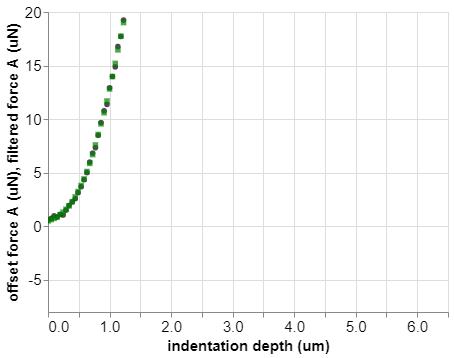

In [16]:
fileName = 'cycling_tests/in_C2/cell001_corr'
df = df_sample[df_sample['fileName']==fileName]

# parameters for Savitzky-Golay filter
window_length = 25 # number of data points in moving window at any given time in filter
polyorder = 2 # order of polynomial to fit in filter
  
# reset row numbers
df = df.reset_index(drop=True)
    
# separate indenting and retraction data for filter
df_indent = df[df['indenting']]
df_retract = df[~df['indenting'].astype('bool')]
    
# filter indenting and retraction data
f_filt_ind = signal.savgol_filter(df_indent['offset force A (uN)'], window_length, polyorder) 
f_filt_ret = signal.savgol_filter(df_retract['offset force A (uN)'], window_length, polyorder)
    
# copy filtered data onto appropriate slices of dataframe
df.loc[df['indenting'],'filtered force A (uN)'] = f_filt_ind
df.loc[~df['indenting'].astype('bool'),'filtered force A (uN)'] = f_filt_ret

unfiltered_chart = alt.Chart(df[df['indenting']]).mark_circle().encode(
    x=alt.X('indentation depth (um)',scale=alt.Scale(domain=(0.0,6.5))),
    y=alt.Y('offset force A (uN)',scale=alt.Scale(domain=(-7.0,20.0))),
    color=alt.value('black')
)
filtered_chart = alt.Chart(df[df['indenting']]).mark_square().encode(
    x=alt.X('indentation depth (um)',scale=alt.Scale(domain=(0.0,6.5))),
    y=alt.Y('filtered force A (uN)',scale=alt.Scale(domain=(-7.0,20.0))),
    color=alt.value('green')
)
(unfiltered_chart+filtered_chart).configure_axis(grid=True,
    labelFontSize=15,
    titleFontSize=15).interactive()

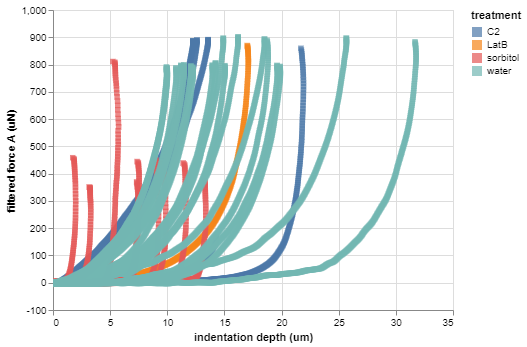

In [17]:
# loop through each data set and run Savitzky-Golay filter
df_sample['filtered force A (uN)'] = 0 # initialize new column in dataframe
window_length = 25 # number of data points in moving window at any given time in filter
polyorder = 2 # order of polynomial to fit in filter
for fileName in df_sample['fileName'].unique():
    # separate by experiment label
    df = df_sample[df_sample['fileName']==fileName]
    
    # reset row numbers and set initial force to 0.0
    df = df.reset_index(drop=True)
    df['offset force A (uN)'] = df['offset force A (uN)'] - df['offset force A (uN)'][0] 
    
    # separate indenting and retraction data for filter
    df_indent = df[df['indenting']]
    df_retract = df[~df['indenting'].astype('bool')]
    
    # filter indenting and retraction data
    f_filt_ind = signal.savgol_filter(df_indent['offset force A (uN)'], window_length, polyorder)
    # copy filtered data onto appropriate slices of dataframe
    df_sample.loc[(df_sample['fileName']==fileName)&(df_sample['indenting']),'filtered force A (uN)'] = f_filt_ind
    if len(df_retract)!=0:
        # only filter if retraction data exists
        f_filt_ret = signal.savgol_filter(df_retract['offset force A (uN)'], window_length, polyorder)
        # copy filtered data onto appropriate slices of dataframe
        df_sample.loc[(df_sample['fileName']==fileName)&(~df_sample['indenting'].astype('bool')),'filtered force A (uN)'] = f_filt_ret

# take a look
# TO DO: Check what's happening with sorbitol cases at neg indentation depth
alt.Chart(df_sample[(~df_sample['indenting'].astype('bool'))&(df_sample['indentation depth (um)']>0)]).mark_square().encode(
    x='indentation depth (um)',
    y='filtered force A (uN)',
    color = 'treatment:N'
).interactive()

### Fit a line to initial part of indentation curve

Like we did in the contact finding section, we'll first take a look at one example case, and then apply the same procedure to all data sets in a loop.

cycling_tests/in_C2/cell001_corr 12.058493537848902


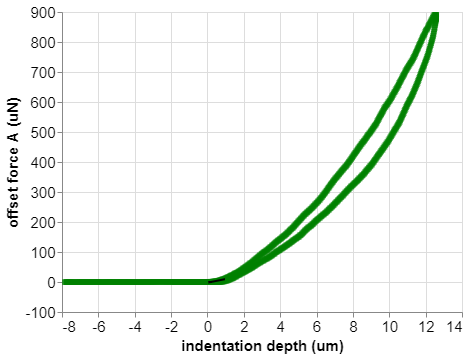

In [18]:
fileName = 'cycling_tests/in_C2/cell001_corr'
df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN
name = df['fileName'][0]

# only take indentation data
df = df[df['indenting']]

# set initial force and displacement to (0,0)
df = df[df['indentation depth (um)']>0.0].reset_index(drop=True)
df['filtered force A (uN)'] = df['filtered force A (uN)'] - df['filtered force A (uN)'][0] 

# take first 1um of displacement after touching cell if over cell wall
df_init = df[(df['indentation depth (um)']<1.0)&(df['indentation depth (um)']>=0.0)]

# Now perform a linear fit
f = np.polyfit(df_init['indentation depth (um)'], df_init['filtered force A (uN)'], 1)

# Add the linear fit to the plot
displ = df_init['indentation depth (um)']
force = f[0]*displ + f[1]
kref = f[0]
treatment = df['treatment'][0]
names = name
df_linfit = pd.DataFrame({'indentation depth (um)': displ, 'offset force A (uN)': force})
print(name, f[0])

df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

# Take a look
chart_data = alt.Chart(df).mark_square().encode(
    x=alt.X('indentation depth (um)'), # scale=alt.Scale(domain=(0,2.0))),
    y=alt.Y('offset force A (uN)'), # scale=alt.Scale(domain=(0,10.0))),
    color = alt.value('green')
)
chart_fit = alt.Chart(df_linfit).mark_line().encode(
    x=alt.X('indentation depth (um)'), # scale=alt.Scale(domain=(0,2.0))),
    y=alt.Y('offset force A (uN)'), # scale=alt.Scale(domain=(0,10.0))),
    color=alt.value('black')
)
(chart_data + chart_fit).configure_axis(grid=True,
    labelFontSize=15,
    titleFontSize=15).interactive()

In [19]:
df_sample.head()

,Index,Time (s),Displacement (um),Pos X (um),Pos Y (um),Pos Z (um),Force A (uN),Force B (uN),fileName,indenting,Full Indentation,plasmolyzed,treatment,Corrected Displacement (um),offset force A (uN),cellNum,threshold,cycle,indentation depth (um),filtered force A (uN)
0,1.001,0.123,0.20325,184.00625,-106.00100,49.77075,-10.54090,-0.00129,cycling_tests/in_C2/cell001_corr,True,True,False,C2,0.244673,-0.286136,1,0.5,1.0,-7.853853,-0.131540
1,1.001,0.228,0.27500,184.00700,-106.00125,49.69900,-10.88703,-0.00336,cycling_tests/in_C2/cell001_corr,True,True,False,C2,0.317783,-0.632266,1,0.5,1.0,-7.780742,-0.141707
2,1.001,0.346,0.30325,184.00700,-106.00075,49.67075,-10.78654,-0.00192,cycling_tests/in_C2/cell001_corr,True,True,False,C2,0.345638,-0.531776,1,0.5,1.0,-7.752887,-0.149410
3,1.001,0.466,0.32000,184.00625,-106.00100,49.65400,-10.74826,0.00253,cycling_tests/in_C2/cell001_corr,True,True,False,C2,0.362238,-0.493496,1,0.5,1.0,-7.736288,-0.154647
4,1.001,0.595,0.34275,184.00600,-106.00075,49.63125,-10.73709,0.00397,cycling_tests/in_C2/cell001_corr,True,True,False,C2,0.384944,-0.482326,1,0.5,1.0,-7.713582,-0.157420


In [20]:
kref = np.empty(len(df_sample['fileName'].unique()))
deltaF = np.empty(len(df_sample['fileName'].unique()))
treatment = ['' for x in range(len(df_sample['fileName'].unique()))]
names = ['' for x in range(len(df_sample['fileName'].unique()))]
cycle = np.empty(len(df_sample['fileName'].unique()))
maxF = np.empty(len(df_sample['fileName'].unique()))
df_linfit_concat = pd.DataFrame(columns=['offset force A (uN)','indentation depth (um)'])
i=0

for fileName in df_sample['fileName'].unique():
    df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

    # only take indentation data
    df = df[df['indenting']]
    
    # set initial force and displacement to (0,0)
    df = df[df['indentation depth (um)']>0.0].reset_index(drop=True)
    df['filtered force A (uN)'] = df['filtered force A (uN)'] - df['filtered force A (uN)'][0] 

    # if contact detected, find initial stiffness
    if max(df['indentation depth (um)'])>0.0:

        # take first 1um of displacement after touching cell if over cell wall
        df_glass = df[(df['indentation depth (um)']<1.0)&(df['indentation depth (um)']>=0.0)]

        # Now perform a linear fit
        f = np.polyfit(df_glass['indentation depth (um)'], df_glass['filtered force A (uN)'], 1)
        
        # Add the linear fit to the plot
        displ = df_glass['indentation depth (um)']
        force = f[0]*displ + f[1]
        maxF[i] = max(df['offset force A (uN)'])
        kref[i] = f[0]
        treatment[i] = df['treatment'][0]
        cycle[i] = df['cycle'][0]
        names[i] = fileName
        df_linfit = pd.DataFrame({'indentation depth (um)': displ, 'filtered force A (uN)': force})
        df_linfit_concat = pd.concat([df_linfit, df_linfit_concat], sort=False)
        
        # measure "strength" by measuring delta force required for 1.0um of indentation
        deltaF[i] = max(df[df['indentation depth (um)']<1.0]['filtered force A (uN)'])
    
    # if contact not detected, fill in data for df_kref
    else:
        kref[i] = 0.0
        maxF[i] = max(df['offset force A (uN)'])
        treatment[i] = 'no contact detected'
        cycle[i] = df['cycle'][0]
        names[i] = fileName
        # measure "strength" by measuring delta force required for 1.0um of indentation
        deltaF[i] = max(df[df['indentation depth (um)']<1.0]['filtered force A (uN)'])
        
    if deltaF[i]>700:
        print(fileName)
    i+=1
    
df_kref = pd.DataFrame({'name':names, 'max force (uN)': maxF, 'kinit': kref, 'deltaF':deltaF, 'treatment': treatment, 'cycle':cycle})

In [30]:
len(df_kref[(df_kref['treatment']=='water')&(df_kref['cycle']==3)])

4

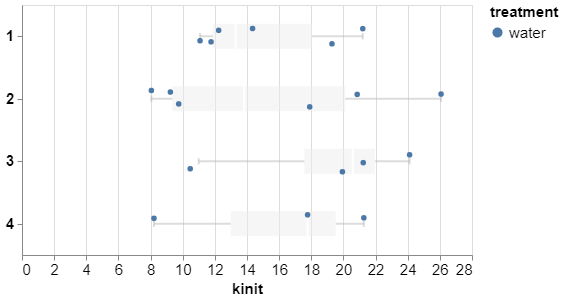

In [27]:
# // box+jitter plot with outliers removed
# the box_mark argument sets the style of the bar
# the whisker_mark argument sets the style for the error bar
# (to select different colors, you'll want to google "hex color code")
# for mark type, you can use point, circle, square, etc. (not sure how to pick the size just yet)
altcat.catplot(df_kref[(df_kref['treatment']=='water')&(df_kref['kinit']>0)&(df_kref['kinit']<100)],
               height=250,
               width=450,
               mark=dict(opacity=1.0, type='circle'),
               box_mark=dict(strokeWidth=2, opacity=0.5, color='#eeeeee'),
               whisker_mark=dict(strokeWidth=2, opacity=0.5, color='#bababa'),
               encoding=dict(y=alt.Y('cycle:N'),
                             x='kinit:Q',                             
                             color=alt.Color('treatment:N'),
                             tooltip=alt.Tooltip(['name:N'], title='name')),
               transform='jitterbox'
              ).configure_text(
                  fontWeight='bold', fontSize=15
              ).configure_legend(labelFontSize=15,
    titleFontSize=15).configure_axis(labelFontSize=15, titleFontSize=15)

### (8) Fit line to initial part of retraction curve
As is common with AFM force measurements, we'll try fitting a line to the initial portion of the retraction curve. I expect that this method will only work for turgid ("strong") cells, because the plasmolyzed cells fail before we reach the force threshold. So, the initial portion of the retraction curve in plasmolyzed cases only represents the stiffness of the glass slide.

cycling_tests/in_water/cell128C_corr 273.1497820846554


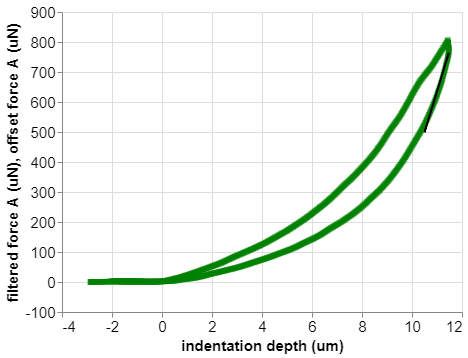

In [33]:
fileName = 'cycling_tests/in_water/cell128C_corr'
df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN
name = df['fileName'][0]

# only take retraction data
df = df[~df['indenting'].astype('bool')]

# set initial force and displacement to (0,0)
df = df[df['indentation depth (um)']>0.0].reset_index(drop=True)
df['filtered force A (uN)'] = df['filtered force A (uN)'] - df['filtered force A (uN)'].iloc[-1] 

# take first 1um of displacement after reaching max force
df_init = df[(df['indentation depth (um)']>max(df['indentation depth (um)'])-1)]

# Now perform a linear fit
f = np.polyfit(df_init['indentation depth (um)'], df_init['filtered force A (uN)'], 1)

# Add the linear fit to the plot
displ = df_init['indentation depth (um)']
force = f[0]*displ + f[1]
kref = f[0]
treatment = df['treatment'][0]
names = name
df_linfit = pd.DataFrame({'indentation depth (um)': displ, 'offset force A (uN)': force})
print(name, f[0])

df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

# Take a look
chart_data = alt.Chart(df).mark_square().encode(
    x=alt.X('indentation depth (um)'), # scale=alt.Scale(domain=(0,2.0))),
    y=alt.Y('filtered force A (uN)'), # scale=alt.Scale(domain=(0,10.0))),
    color = alt.value('green')
)
chart_fit = alt.Chart(df_linfit).mark_line().encode(
    x=alt.X('indentation depth (um)'), # scale=alt.Scale(domain=(0,2.0))),
    y=alt.Y('offset force A (uN)'), # scale=alt.Scale(domain=(0,10.0))),
    color=alt.value('black')
)
(chart_data+chart_fit).configure_axis(grid=True,
    labelFontSize=15,
    titleFontSize=15).interactive()

In [34]:
kref = np.empty(len(df_sample['fileName'].unique()))
treatment = ['' for x in range(len(df_sample['fileName'].unique()))]
names = ['' for x in range(len(df_sample['fileName'].unique()))]
maxF = np.empty(len(df_sample['fileName'].unique()))
df_linfit_concat = pd.DataFrame(columns=['offset force A (uN)','indentation depth (um)'])
i=0

for fileName in df_sample['fileName'].unique():
    df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

    # only take retraction data
    df = df[~df['indenting'].astype('bool')]
    
    # set initial force and displacement to (0,0)
    df = df[df['indentation depth (um)']>0.0].reset_index(drop=True)
    df['filtered force A (uN)'] = df['filtered force A (uN)'] - df['filtered force A (uN)'].iloc[-1] 

    # if contact detected, find initial stiffness
    if max(df['indentation depth (um)'])>0.0:
        
        # take first 1um of displacement after reaching max force
        df_glass = df[(df['indentation depth (um)']>max(df['indentation depth (um)'])-1)]

        # Now perform a linear fit
        f = np.polyfit(df_glass['indentation depth (um)'], df_glass['filtered force A (uN)'], 1)
        
        # Add the linear fit to the plot
        displ = df_glass['indentation depth (um)']
        force = f[0]*displ + f[1]
        maxF[i] = max(df['offset force A (uN)'])
        kref[i] = f[0]
        treatment[i] = df['treatment'].iloc[-1]
        names[i] = fileName
        df_linfit = pd.DataFrame({'indentation depth (um)': displ, 'filtered force A (uN)': force})
        df_linfit_concat = pd.concat([df_linfit, df_linfit_concat], sort=False)
           
    # if contact not detected, fill in data for df_kref
    else:
        kref[i] = 0.0
        maxF[i] = max(df['offset force A (uN)'])
        treatment[i] = 'no contact detected'
        locations[i] = df['location'][0]
        names[i] = fileName
    
    df_kref.loc[df_kref['name']==fileName, 'kret'] = kref[i]
    i+=1
    
df_kref.head()

,name,max force (uN),kinit,deltaF,treatment,cycle,kret
0,cycling_tests/in_C2/cell001_corr,899.143144,12.058494,11.068975,C2,1.0,218.615234
1,cycling_tests/in_C2/cell001B_corr,895.918818,27.849221,25.820010,C2,2.0,198.504556
2,cycling_tests/in_C2/cell001C_corr,895.340638,23.345119,21.053635,C2,3.0,216.064624
3,cycling_tests/in_C2/cell001D_corr,897.980526,7.657422,7.448198,C2,4.0,185.847891
4,cycling_tests/in_C2/cell011_corr,169.468483,2.148068,2.195033,C2,1.0,78.509318


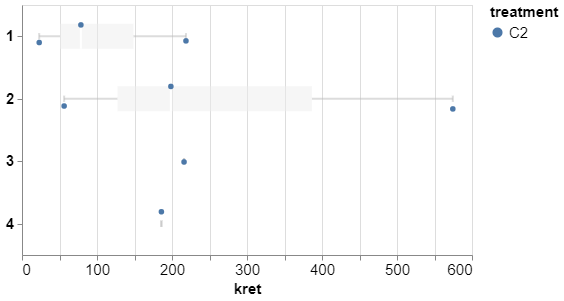

In [38]:
altcat.catplot(df_kref[(df_kref['treatment']=='C2')],
               height=250,
               width=450,
               mark=dict(opacity=1.0, type='circle'),
               box_mark=dict(strokeWidth=2, opacity=0.5, color='#eeeeee'),
               whisker_mark=dict(strokeWidth=2, opacity=0.5, color='#bababa'),
               encoding=dict(y=alt.Y('cycle:N'),
                             x='kret:Q',
                             color=alt.Color('treatment:N'),
                             tooltip=alt.Tooltip(['name:N'], title='name')),
               transform='jitterbox'
              ).configure_text(
                  fontWeight='bold', fontSize=15
              ).configure_legend(labelFontSize=15,
    titleFontSize=15).configure_axis(labelFontSize=15, titleFontSize=15)

### Calculate the sample recovery

The sample recovery, $R$, is defined as the displacement recovered at the end of each compression cycle, divided by the maximum displacement, according to the following formula:

$R = \frac{\varepsilon_{max}-\varepsilon_{unload}}{\varepsilon_{max}}$

where $\varepsilon_{max}$ is the maximum displacement at the end of the compression cycle, and $\varepsilon_{unload}$ is the displacement after unloading to 10% of the maximum load in each cycle.

In [55]:
fileName = 'cycling_tests/in_water/cell128C_corr'
df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

# calculate maximum displacement
emax = max(df['indentation depth (um)'])

# calculate maximum load
maxload = max(df['offset force A (uN)'])

# only use retraction data to find displacement at 10% of maximum load
df = df[~df['indenting'].astype('bool')]
eunload = max(df[df['offset force A (uN)']<0.1*maxload]['indentation depth (um)'])

# calculate sample recovery
R = (emax-eunload)/emax
R

0.6339053850057039

In [56]:
for fileName in df_sample['fileName'].unique():
    df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN
   
    # calculate maximum displacement
    emax = max(df['indentation depth (um)'])

    # calculate maximum load
    maxload = max(df['offset force A (uN)'])

    # only use retraction data to find displacement at 10% of maximum load
    df = df[~df['indenting'].astype('bool')]
    eunload = max(df[df['offset force A (uN)']<0.1*maxload]['indentation depth (um)'])

    # calculate sample recovery
    R = (emax-eunload)/emax
    
    df_kref.loc[df_kref['name']==fileName, 'R'] = R
    
df_kref.head()

,name,max force (uN),kinit,deltaF,treatment,cycle,kret,R
0,cycling_tests/in_C2/cell001_corr,899.143144,12.058494,11.068975,C2,1.0,218.615234,0.720323
1,cycling_tests/in_C2/cell001B_corr,895.918818,27.849221,25.820010,C2,2.0,198.504556,0.736786
2,cycling_tests/in_C2/cell001C_corr,895.340638,23.345119,21.053635,C2,3.0,216.064624,0.744311
3,cycling_tests/in_C2/cell001D_corr,897.980526,7.657422,7.448198,C2,4.0,185.847891,0.683285
4,cycling_tests/in_C2/cell011_corr,169.468483,2.148068,2.195033,C2,1.0,78.509318,0.393712


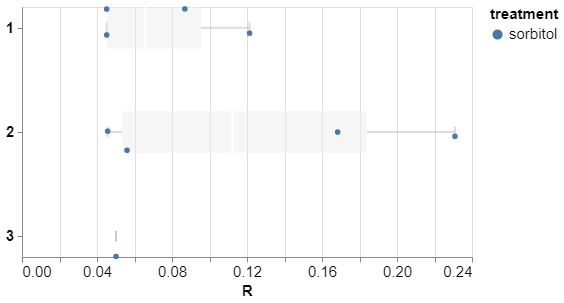

In [60]:
altcat.catplot(df_kref[(df_kref['treatment']=='sorbitol')],
               height=250,
               width=450,
               mark=dict(opacity=1.0, type='circle'),
               box_mark=dict(strokeWidth=2, opacity=0.5, color='#eeeeee'),
               whisker_mark=dict(strokeWidth=2, opacity=0.5, color='#bababa'),
               encoding=dict(y=alt.Y('cycle:N'),
                             x='R:Q',
                             color=alt.Color('treatment:N'),
                             tooltip=alt.Tooltip(['name:N'], title='name')),
               transform='jitterbox'
              ).configure_text(
                  fontWeight='bold', fontSize=15
              ).configure_legend(labelFontSize=15,
    titleFontSize=15).configure_axis(labelFontSize=15, titleFontSize=15)

### Calculate the loss coefficient

The loss coefficient, $\eta$, measures energy dissipation and is calculated as follows:

$\eta = \frac{\Delta U_i}{2 \pi U_1}$

where $U_1$ is the elastic energy stored in the material when it is loaded elastically to a stress $\sigma_{max}$ during the first cycle, and $\Delta U_i$ is the energy dissipated in the $i$th cycle.

In [64]:
# cycle 1
fileName = 'cycling_tests/in_water/cell128_corr'
df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

In [62]:
displ = df[df['indentation depth (um)']>0]['indentation depth (um)'].reset_index(drop=True)
force = df[df['indentation depth (um)']>0]['offset force A (uN)'].reset_index(drop=True)

In [65]:
U1 = 0
for i in range(len(displ)):
    if i==len(displ)-1:
        U1 += displ[i] * force[0] - force[i] * displ[0]
    else:
        U1 += displ[i] * force[i+1] - force[i] * displ[i+1]
U1 = abs(U1*0.5)
print(U1)

957.081079057496


In [66]:
# cycle 2
fileName = 'cycling_tests/in_water/cell128B_corr'
df = df_sample[df_sample['fileName']==fileName].reset_index(drop=True) # need to reset index since we dropped rows with NaN

In [67]:
displ = df[df['indentation depth (um)']>0]['indentation depth (um)'].reset_index(drop=True)
force = df[df['indentation depth (um)']>0]['offset force A (uN)'].reset_index(drop=True)

U2 = 0
for i in range(len(displ)):
    if i==len(displ)-1:
        U2 += displ[i] * force[0] - force[i] * displ[0]
    else:
        U2 += displ[i] * force[i+1] - force[i] * displ[i+1]
U2 = abs(U2*0.5)
print(U2)

1149.025549156258


In [70]:
eta = U2/2/np.pi/U1
eta

0.19107377618120486

In [71]:
df.head()

,Index,Time (s),Displacement (um),Pos X (um),Pos Y (um),Pos Z (um),Force A (uN),Force B (uN),fileName,indenting,Full Indentation,plasmolyzed,treatment,Corrected Displacement (um),offset force A (uN),cellNum,threshold,cycle,indentation depth (um),filtered force A (uN)
0,1.001,0.107,0.03800,-348.01650,-134.06175,-429.94600,-16.40537,-0.00594,cycling_tests/in_water/cell128B_corr,True,False,False,water,0.102469,0.207951,128,1.0,2.0,-2.583586,-0.031739
1,1.001,0.207,0.06625,-348.01625,-134.06200,-429.97425,-16.30674,-0.00419,cycling_tests/in_water/cell128B_corr,True,False,False,water,0.130331,0.306581,128,1.0,2.0,-2.555724,-0.085491
2,1.001,0.317,0.08175,-348.01700,-134.06200,-429.98975,-16.73470,-0.01072,cycling_tests/in_water/cell128B_corr,True,False,False,water,0.147513,-0.121379,128,1.0,2.0,-2.538542,-0.140163
3,1.001,0.427,0.09850,-348.01650,-134.06200,-430.00650,-16.59788,-0.00737,cycling_tests/in_water/cell128B_corr,True,False,False,water,0.163726,0.015441,128,1.0,2.0,-2.522330,-0.195755
4,1.001,0.539,0.12025,-348.01600,-134.06200,-430.02825,-16.96379,-0.01326,cycling_tests/in_water/cell128B_corr,True,False,False,water,0.186914,-0.350469,128,1.0,2.0,-2.499142,-0.252267


In [79]:
for cellNum in df_sample['cellNum'].unique():
    df_allcycles = df_sample[df_sample['cellNum']==cellNum]

    for cycle in df_allcycles['cycle'].unique():
        df = df_allcycles[df_allcycles['cycle']==cycle]
        fileName = df['fileName'].reset_index(drop=True)[0]
        displ = df[df['indentation depth (um)']>0]['indentation depth (um)'].reset_index(drop=True)
        force = df[df['indentation depth (um)']>0]['offset force A (uN)'].reset_index(drop=True)

        U = 0
        for i in range(len(displ)):
            if i==len(displ)-1:
                U += displ[i] * force[0] - force[i] * displ[0]
            else:
                U += displ[i] * force[i+1] - force[i] * displ[i+1]
        U = abs(U*0.5)
        if cycle==1.0:
            U1 = U
        eta = U/2/np.pi/U1
        
        df_kref.loc[df_kref['name']==fileName, 'eta'] = eta
df_kref.head()

,name,max force (uN),kinit,deltaF,treatment,cycle,kret,R,eta
0,cycling_tests/in_C2/cell001_corr,899.143144,12.058494,11.068975,C2,1.0,218.615234,0.720323,0.159155
1,cycling_tests/in_C2/cell001B_corr,895.918818,27.849221,25.820010,C2,2.0,198.504556,0.736786,0.152881
2,cycling_tests/in_C2/cell001C_corr,895.340638,23.345119,21.053635,C2,3.0,216.064624,0.744311,0.147949
3,cycling_tests/in_C2/cell001D_corr,897.980526,7.657422,7.448198,C2,4.0,185.847891,0.683285,0.169904
4,cycling_tests/in_C2/cell011_corr,169.468483,2.148068,2.195033,C2,1.0,78.509318,0.393712,0.159155


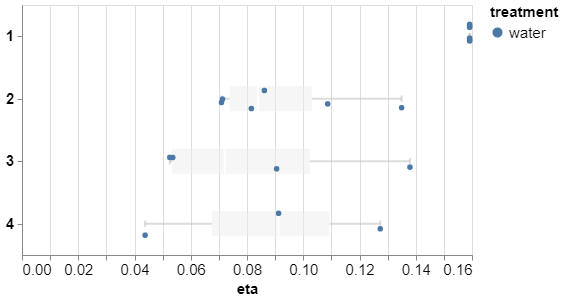

In [82]:
altcat.catplot(df_kref[(df_kref['treatment']=='water')],
               height=250,
               width=450,
               mark=dict(opacity=1.0, type='circle'),
               box_mark=dict(strokeWidth=2, opacity=0.5, color='#eeeeee'),
               whisker_mark=dict(strokeWidth=2, opacity=0.5, color='#bababa'),
               encoding=dict(y=alt.Y('cycle:N'),
                             x='eta:Q',
                             color=alt.Color('treatment:N'),
                             tooltip=alt.Tooltip(['name:N'], title='name')),
               transform='jitterbox'
              ).configure_text(
                  fontWeight='bold', fontSize=15
              ).configure_legend(labelFontSize=15,
    titleFontSize=15).configure_axis(labelFontSize=15, titleFontSize=15)